# Molecular Property Prediction with Active Learning


In [1]:
!pip install --quiet ase scikit-learn matplotlib pandas tqdm
!pip install --quiet rdkit
!pip install --quiet lightgbm


In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import time
import os
from tqdm import tqdm 
from ase.io import read
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [5]:
# Load the QM9 dataset
import io
import tarfile

# Define QM9 property names
QM9_PROP_NAMES = [
    'tag', 'gdb_id', 'A', 'B', 'C', 'mu', 'alpha',
    'HOMO', 'LUMO', 'gap', 'R2', 'ZPVE', 'U0', 'U', 'H', 'G'
]

# Path to the QM9 tar.bz2 file
TAR_PATH = r'/home/sattar/Documents/Dataset/QM9 data/dsgdb9nsd.xyz.tar.bz2'

all_data = []

print("Loading QM9 dataset...")
try:
    with tarfile.open(TAR_PATH, 'r:bz2') as tar:
        # Get list of .xyz files
        file_list = [f for f in tar.getmembers() if f.name.endswith('.xyz')]
        
        print(f"Processing {len(file_list)} files from the tar archive...")
        
        for member in tqdm(file_list, desc="Reading molecules"):
            try:
                f = tar.extractfile(member)
                if f is not None:
                    xyz_text = f.read().decode('utf-8')
                    lines = xyz_text.strip().split('\n')
                    
                    # Extract properties from the second line
                    props_line = lines[1].split()
                    
                    if len(props_line) >= 16:
                        data_row = {QM9_PROP_NAMES[i]: props_line[i] for i in range(16)}
                        
                        # Extract SMILES from the second to last line
                        smiles_line = lines[-2].split()
                        if len(smiles_line) >= 1:
                            data_row['smiles_canonical'] = smiles_line[0]
                        else:
                            data_row['smiles_canonical'] = None
                        
                        all_data.append(data_row)
            except Exception as e:
                # Skip files with errors
                continue

except FileNotFoundError:
    print(f"Error: TAR file not found at {TAR_PATH}. Please check the path.")
except Exception as e:
    print(f"An error occurred: {e}")

# Create DataFrame from collected data
df = pd.DataFrame(all_data)

# Convert relevant columns to numeric types
numeric_cols = QM9_PROP_NAMES[2:] 
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Remove rows with missing SMILES (only if column exists)
if 'smiles_canonical' in df.columns:
    df = df.dropna(subset=['smiles_canonical'])

# Display the first few rows and the shape of the DataFrame
print(f"\nDataset loaded successfully!")
print(f"Shape: {df.shape}")
display(df.head())
print(f"\nTarget properties available: {numeric_cols}")


Loading QM9 dataset...
Processing 133885 files from the tar archive...
Processing 133885 files from the tar archive...


Reading molecules: 100%|██████████| 133885/133885 [00:06<00:00, 21238.09it/s]




Dataset loaded successfully!
Shape: (133885, 17)


,tag,gdb_id,A,B,C,mu,alpha,HOMO,LUMO,gap,R2,ZPVE,U0,U,H,G,smiles_canonical
0,gdb,1,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,C
1,gdb,2,293.60975,293.541110,191.393970,1.6256,9.46,-0.2570,0.0829,0.3399,26.1563,0.034358,-56.525887,-56.523026,-56.522082,-56.544961,N
2,gdb,3,799.58812,437.903860,282.945450,1.8511,6.31,-0.2928,0.0687,0.3615,19.0002,0.021375,-76.404702,-76.401867,-76.400922,-76.422349,O
3,gdb,4,0.00000,35.610036,35.610036,0.0000,16.28,-0.2845,0.0506,0.3351,59.5248,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,C#C
4,gdb,5,0.00000,44.593883,44.593883,2.8937,12.99,-0.3604,0.0191,0.3796,48.7476,0.016601,-93.411888,-93.409370,-93.408425,-93.431246,C#N



Target properties available: ['A', 'B', 'C', 'mu', 'alpha', 'HOMO', 'LUMO', 'gap', 'R2', 'ZPVE', 'U0', 'U', 'H', 'G']


In [7]:
# EV-CM (Eigenvalue Coulomb Matrix) pipeline + LightGBM modeling
# - Split 80/10/10, scale, RandomizedSearchCV for LightGBM, evaluate on test set

import tarfile
import gc
import pickle
import joblib
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor

print("Starting EV-CM pipeline...")

# Paths
TAR_PATH = r'/home/sattar/Documents/Dataset/QM9 data/dsgdb9nsd.xyz.tar.bz2'
memmap_file = r'/home/sattar/Documents/Dataset/QM9 data/evcm_memmap.dat'
pickle_file = r'/home/sattar/Documents/Dataset/QM9 data/evcm_eigvals.pkl'

# Get list of members
with tarfile.open(TAR_PATH, 'r:bz2') as tar:
    file_list = [m for m in tar.getmembers() if m.name.endswith('.xyz')]

N = len(file_list)
print(f"Total .xyz files in archive: {N}")

# Quick pass: determine max atoms and gather gdb ids in archive order
max_atoms = 0
gdb_ids = []
print("Determining maximum atom count and collecting gdb ids (fast pass)...")
with tarfile.open(TAR_PATH, 'r:bz2') as tar:
    for member in tqdm(file_list, desc="Scan files"):
        f = tar.extractfile(member)
        if f is None:
            gdb_ids.append(None)
            continue
        txt = f.read().decode('utf-8')
        lines = txt.strip().split('\n')
        try:
            n_atoms = int(lines[0].strip())
        except Exception:
            # fallback: try to parse first token
            try:
                n_atoms = int(lines[0].split()[0])
            except Exception:
                n_atoms = 0
        max_atoms = max(max_atoms, n_atoms)
        # get gdb id from second line if possible
        if len(lines) > 1:
            props = lines[1].split()
            if len(props) > 1:
                gdb_ids.append(str(props[1]))
            else:
                gdb_ids.append(None)
        else:
            gdb_ids.append(None)

print(f"Max atoms found: {max_atoms}")

# Create memmap for eigenvalues (float32)
if os.path.exists(memmap_file):
    print(f"Removing existing memmap file: {memmap_file}")
    os.remove(memmap_file)

evcm_mm = np.memmap(memmap_file, dtype='float32', mode='w+', shape=(N, max_atoms))

# Helper: compute Coulomb matrix eigenvalues
pt = Chem.GetPeriodicTable()

def parse_xyz_text_to_symbols_coords(txt):
    lines = txt.strip().split('\n')
    if len(lines) < 2:
        return [], np.zeros((0, 3))
    try:
        n_atoms = int(lines[0].strip())
    except Exception:
        n_atoms = 0
    atom_lines = lines[2:2 + n_atoms]
    symbols = []
    coords = []
    for a in atom_lines:
        parts = a.split()
        if len(parts) < 4:
            continue
        sym = parts[0]
        try:
            x, y, z = float(parts[1]), float(parts[2]), float(parts[3])
        except Exception:
            x = y = z = 0.0
        symbols.append(sym)
        coords.append([x, y, z])
    if len(coords) == 0:
        coords = np.zeros((0, 3), dtype=float)
    else:
        coords = np.array(coords, dtype=float)
    return symbols, coords


def coulomb_eigvals(symbols, coords, max_len):
    n = len(symbols)
    if n == 0:
        return np.zeros(max_len, dtype=np.float32)
    Z = np.array([pt.GetAtomicNumber(s) if pt.GetAtomicNumber(s) is not None else 0 for s in symbols], dtype=float)
    M = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(n):
            if i == j:
                M[i, i] = 0.5 * (Z[i] ** 2.4) if Z[i] > 0 else 0.0
            else:
                dist = np.linalg.norm(coords[i] - coords[j])
                if dist <= 1e-12:
                    val = 0.0
                else:
                    val = (Z[i] * Z[j]) / dist
                M[i, j] = val
    # eigenvalues
    try:
        eigs = np.linalg.eigvalsh(M)
    except Exception:
        eigs = np.zeros(n)
    eigs_sorted = np.sort(eigs)[::-1]
    if len(eigs_sorted) < max_len:
        padded = np.zeros(max_len, dtype=np.float32)
        padded[:len(eigs_sorted)] = eigs_sorted
    else:
        padded = eigs_sorted[:max_len].astype(np.float32)
    return padded

# Second pass: compute eigenvalues into memmap
print("Computing eigenvalues (this can take a while). Writing to memmap incrementally...")
with tarfile.open(TAR_PATH, 'r:bz2') as tar:
    for idx, member in enumerate(tqdm(file_list, desc="Compute EV-CM")):
        try:
            f = tar.extractfile(member)
            if f is None:
                evcm_mm[idx, :] = 0.0
                continue
            txt = f.read().decode('utf-8')
            symbols, coords = parse_xyz_text_to_symbols_coords(txt)
            eigvals = coulomb_eigvals(symbols, coords, max_atoms)
            evcm_mm[idx, :] = eigvals
        except Exception as e:
            evcm_mm[idx, :] = 0.0
        if (idx + 1) % 1000 == 0:
            evcm_mm.flush()
            gc.collect()

# Final flush
evcm_mm.flush()
print("EV-CM eigenvalues saved to memmap.")

# Build DataFrame with gdb_id index
evcm_df = pd.DataFrame(evcm_mm, index=gdb_ids, columns=[f'evcm_{i+1}' for i in range(max_atoms)])

# Save descriptors using pickle instead of parquet
print(f"Saving EV-CM descriptors to {pickle_file} ...")
with open(pickle_file, 'wb') as pf:
    pickle.dump(evcm_df, pf)
print("Saved EV-CM descriptors.")

# Align with df (df was created earlier by the dataset loading cell)
# Use df's gdb_id to select rows in evcm_df. Ensure types match (string)
df_indexed = df.reset_index(drop=True).copy()
df_indexed['gdb_id'] = df_indexed['gdb_id'].astype(str)
evcm_df.index = evcm_df.index.astype(str)

# Keep only rows where gdb_id is in evcm_df index
mask = df_indexed['gdb_id'].isin(evcm_df.index)
print(f"Molecules with descriptors available: {mask.sum()}/{len(df_indexed)}")

df_final = df_indexed[mask].reset_index(drop=True)
X_evcm = evcm_df.loc[df_final['gdb_id'].astype(str)].reset_index(drop=True).values
y_evcm = df_final['gap'].astype(float).values

print(f"Final feature matrix shape: {X_evcm.shape}")

# Split 80/10/10: first 80% train+val, 20% test then split test into val/test equally
X_train_full, X_hold, y_train_full, y_hold = train_test_split(X_evcm, y_evcm, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_hold, y_hold, test_size=0.5, random_state=42)

print(f"Train: {X_train_full.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_full)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Hyperparameter tuning for LightGBM (RandomizedSearchCV)
print("Starting RandomizedSearchCV for LightGBM...")
param_dist = {
    'num_leaves': [31, 50, 100, 150, 200],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'n_estimators': [100, 300, 500, 800],
    'max_depth': [-1, 5, 10, 20],
    'min_child_samples': [5, 10, 20, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

lgb = LGBMRegressor(objective='regression', random_state=42, n_jobs=-1, verbose=-1)
rs = RandomizedSearchCV(lgb, param_dist, n_iter=40, scoring='r2', cv=3, random_state=42, n_jobs=-1, verbose=2)
rs.fit(X_train, y_train_full)

print(f"Best params: {rs.best_params_}")
print(f"Best CV R^2: {rs.best_score_:.4f}")

best_model = rs.best_estimator_

# Evaluate on validation and test
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

metrics = {
    'train_r2': r2_score(y_train_full, y_train_pred),
    'val_r2': r2_score(y_val, y_val_pred),
    'test_r2': r2_score(y_test, y_test_pred),
    'train_mae': mean_absolute_error(y_train_full, y_train_pred),
    'val_mae': mean_absolute_error(y_val, y_val_pred),
    'test_mae': mean_absolute_error(y_test, y_test_pred),
}

print("\nPerformance:")
for k, v in metrics.items():
    if 'r2' in k:
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v:.4f} eV")

# Save model and scaler
model_file = r'/home/sattar/Documents/Dataset/QM9 data/lgb_evcm_model.joblib'
scaler_file = r'/home/sattar/Documents/Dataset/QM9 data/evcm_scaler.joblib'
joblib.dump(best_model, model_file)
joblib.dump(scaler, scaler_file)
print(f"Saved model to {model_file} and scaler to {scaler_file}")

print("EV-CM pipeline and modeling completed.")


Starting EV-CM pipeline...
Total .xyz files in archive: 133885
Determining maximum atom count and collecting gdb ids (fast pass)...
Total .xyz files in archive: 133885
Determining maximum atom count and collecting gdb ids (fast pass)...


Scan files: 100%|██████████| 133885/133885 [00:05<00:00, 22794.15it/s]



Max atoms found: 29
Removing existing memmap file: /home/sattar/Documents/Dataset/QM9 data/evcm_memmap.dat
Computing eigenvalues (this can take a while). Writing to memmap incrementally...


Compute EV-CM: 100%|██████████| 133885/133885 [01:11<00:00, 1864.37it/s]



EV-CM eigenvalues saved to memmap.
Saving EV-CM descriptors to /home/sattar/Documents/Dataset/QM9 data/evcm_eigvals.pkl ...
Saved EV-CM descriptors.
Molecules with descriptors available: 133885/133885
Final feature matrix shape: (133885, 29)
Train: 107108, Val: 13388, Test: 13389
Starting RandomizedSearchCV for LightGBM...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=20, min_child_samples=5, n_estimators=100, num_leaves=50, subsample=0.8; total time=   5.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=20, min_child_samples=5, n_estimators=100, num_leaves=50, subsample=0.8; total time=   5.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=20, min_child_samples=5, n_estimators=100, num_leaves=50, subsample=0.8; total time=   6.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=20, min_child_samples=5, n_estimators=100, num_leaves=50, subsample=0.8; total time=   6.6s
[CV] 

## Visualization of Results

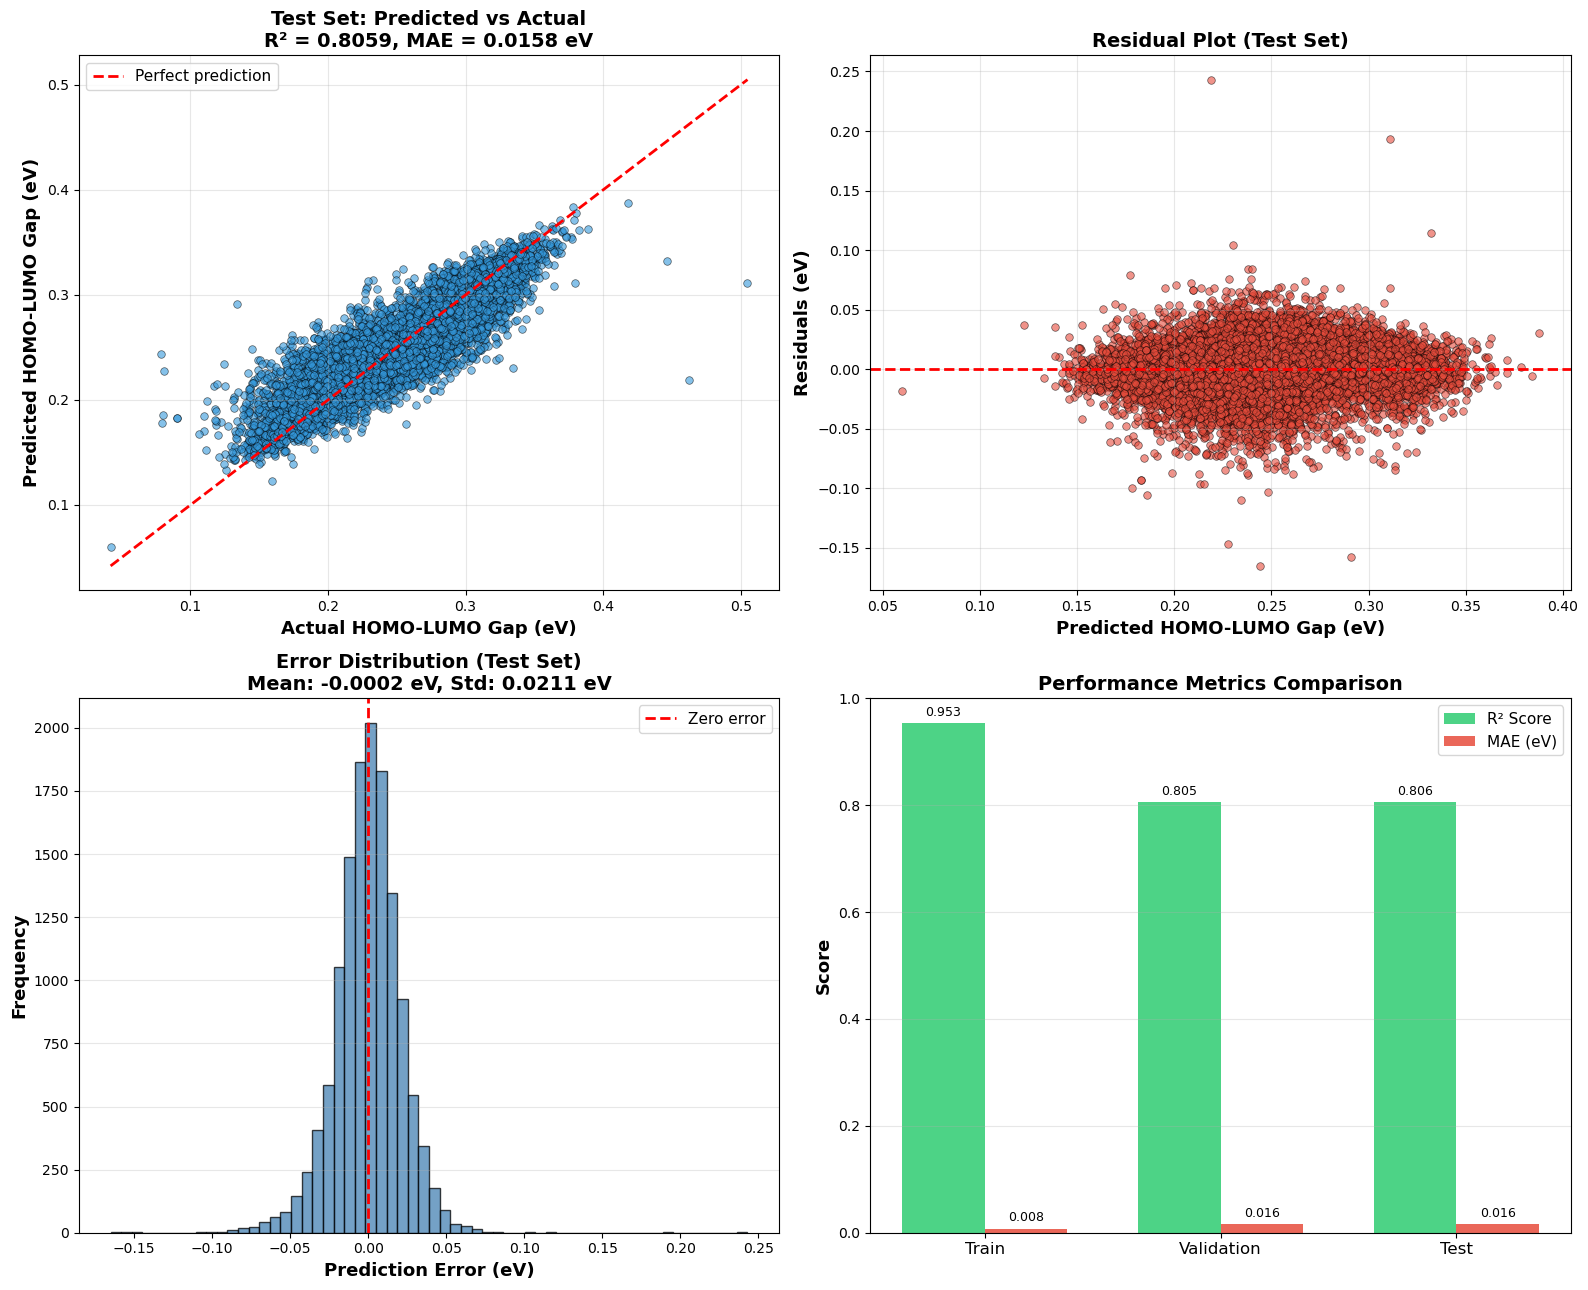


✓ Figure 1: Performance Metrics saved and displayed!


In [8]:
# Visualization 1: Main Performance Metrics (2x2 grid)
fig1, axes = plt.subplots(2, 2, figsize=(16, 13))

# 1. Predicted vs Actual (Test Set)
ax1 = axes[0, 0]
ax1.scatter(y_test, y_test_pred, alpha=0.6, s=30, edgecolors='k', linewidths=0.5, c='#3498db')
min_val, max_val = y_test.min(), y_test.max()
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect prediction')
ax1.set_xlabel('Actual HOMO-LUMO Gap (eV)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Predicted HOMO-LUMO Gap (eV)', fontsize=13, fontweight='bold')
ax1.set_title(f'Test Set: Predicted vs Actual\nR² = {metrics["test_r2"]:.4f}, MAE = {metrics["test_mae"]:.4f} eV', 
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# 2. Residual Plot
residuals = y_test - y_test_pred
ax2 = axes[0, 1]
ax2.scatter(y_test_pred, residuals, alpha=0.6, s=30, edgecolors='k', linewidths=0.5, c='#e74c3c')
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted HOMO-LUMO Gap (eV)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Residuals (eV)', fontsize=13, fontweight='bold')
ax2.set_title('Residual Plot (Test Set)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Error Distribution
ax3 = axes[1, 0]
ax3.hist(residuals, bins=60, alpha=0.75, edgecolor='black', color='steelblue')
ax3.axvline(x=0, color='r', linestyle='--', lw=2, label='Zero error')
ax3.set_xlabel('Prediction Error (eV)', fontsize=13, fontweight='bold')
ax3.set_ylabel('Frequency', fontsize=13, fontweight='bold')
ax3.set_title(f'Error Distribution (Test Set)\nMean: {residuals.mean():.4f} eV, Std: {residuals.std():.4f} eV', 
              fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Performance Metrics Comparison
ax4 = axes[1, 1]
splits = ['Train', 'Validation', 'Test']
r2_scores = [metrics['train_r2'], metrics['val_r2'], metrics['test_r2']]
mae_scores = [metrics['train_mae'], metrics['val_mae'], metrics['test_mae']]

x = np.arange(len(splits))
width = 0.35

bars1 = ax4.bar(x - width/2, r2_scores, width, label='R² Score', alpha=0.85, color='#2ecc71')
bars2 = ax4.bar(x + width/2, mae_scores, width, label='MAE (eV)', alpha=0.85, color='#e74c3c')

ax4.set_ylabel('Score', fontsize=13, fontweight='bold')
ax4.set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(splits, fontsize=12)
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('/home/sattar/Documents/Dataset/QM9 data/fig1_performance_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Figure 1: Performance Metrics saved and displayed!")


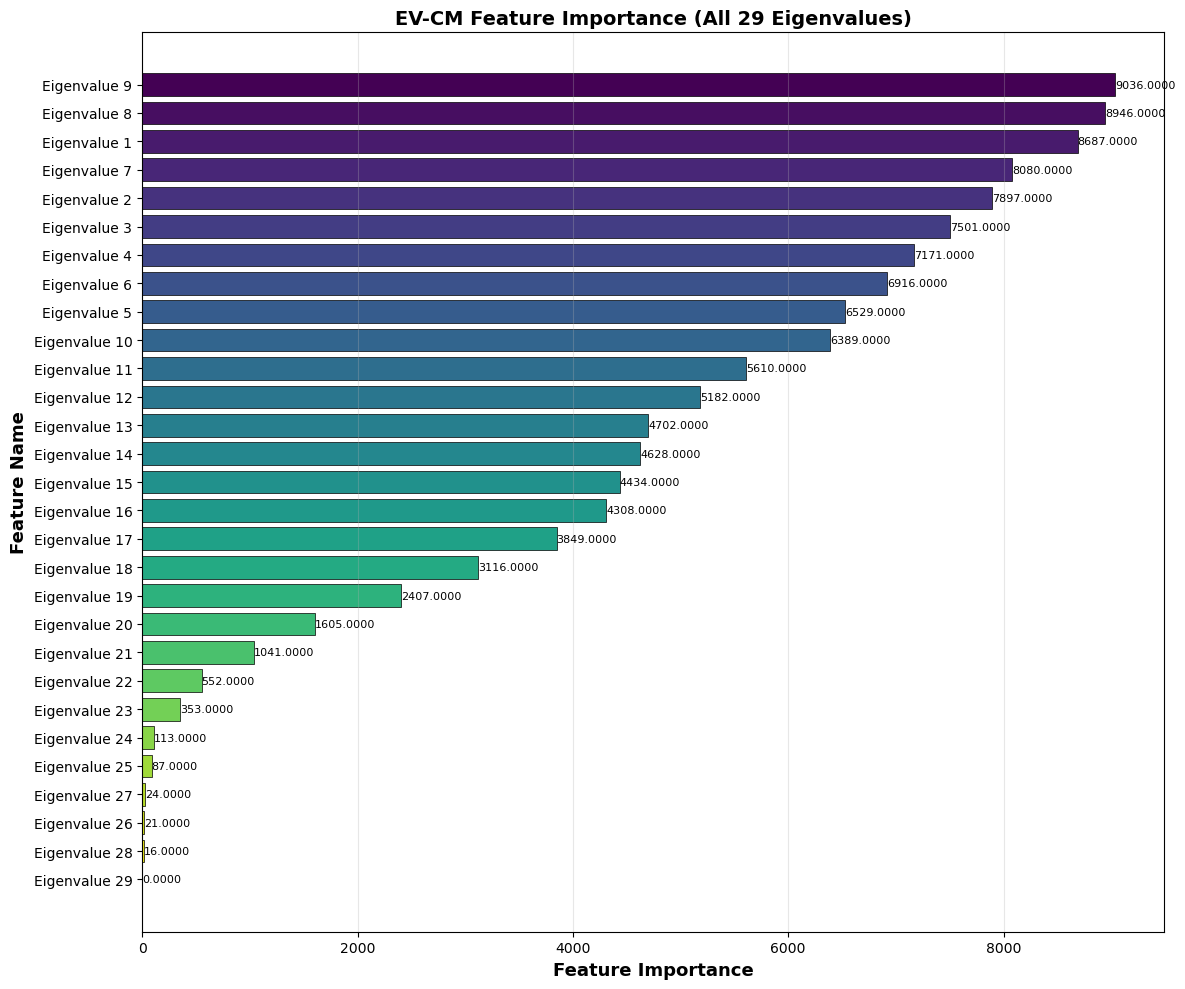


✓ Figure 2: Feature Importance saved and displayed!


In [9]:
# Visualization 2: Feature Importance Analysis
fig2, ax = plt.subplots(1, 1, figsize=(12, 10))

# Get feature importances
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1][:29]  # Top 29 features (all of them)

# Create feature names
feature_names = [f'Eigenvalue {i+1}' for i in range(29)]

# Plot
colors = plt.cm.viridis(np.linspace(0, 1, len(indices)))
bars = ax.barh(range(len(indices)), importances[indices], color=colors, edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(indices)))
ax.set_yticklabels([feature_names[i] for i in indices], fontsize=10)
ax.set_xlabel('Feature Importance', fontsize=13, fontweight='bold')
ax.set_ylabel('Feature Name', fontsize=13, fontweight='bold')
ax.set_title('EV-CM Feature Importance (All 29 Eigenvalues)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

# Add value labels
for i, (bar, val) in enumerate(zip(bars, importances[indices])):
    ax.text(val + 0.001, bar.get_y() + bar.get_height()/2, f'{val:.4f}', 
            va='center', fontsize=8)

plt.tight_layout()
plt.savefig('/home/sattar/Documents/Dataset/QM9 data/fig2_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Figure 2: Feature Importance saved and displayed!")


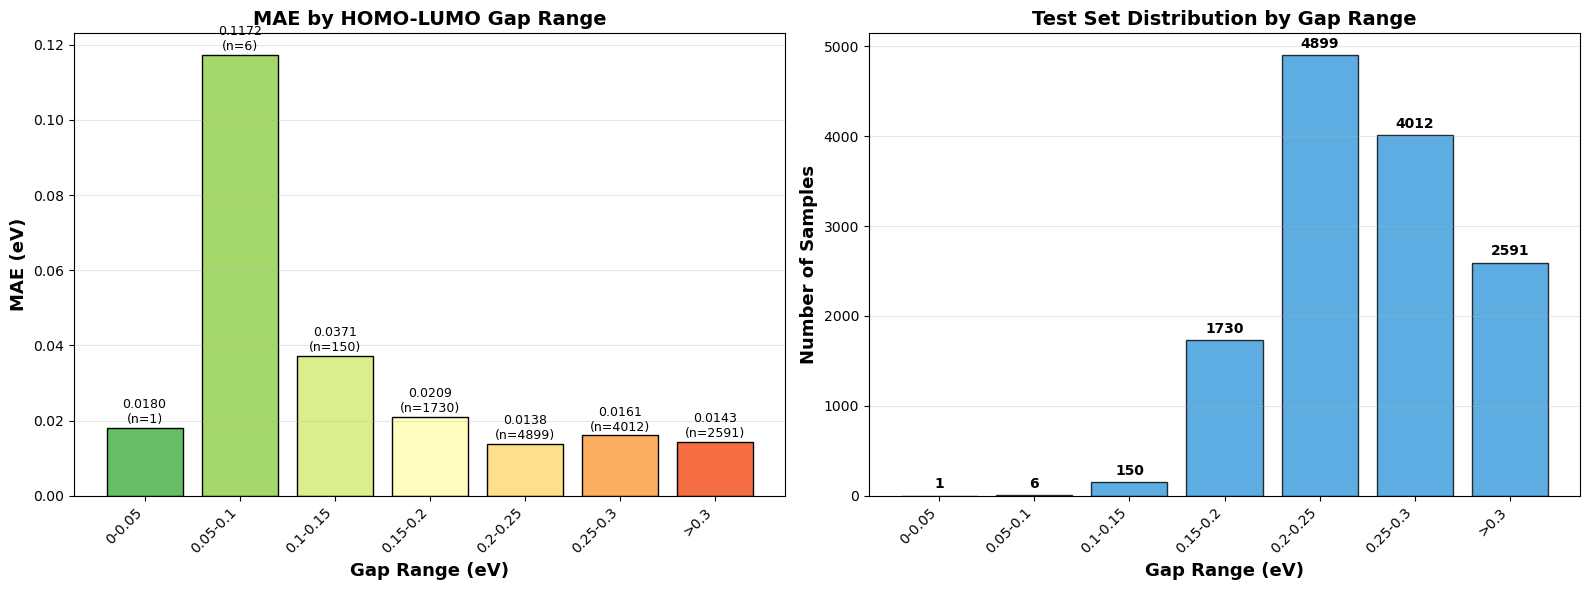


✓ Figure 3: Error Analysis by Gap Range saved and displayed!


In [10]:
# Visualization 3: Error Analysis by Gap Range
fig3, axes = plt.subplots(1, 2, figsize=(16, 6))

# Divide test set into gap ranges
gap_bins = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, y_test.max()]
bin_labels = ['0-0.05', '0.05-0.1', '0.1-0.15', '0.15-0.2', '0.2-0.25', '0.25-0.3', '>0.3']
y_test_binned = pd.cut(y_test, bins=gap_bins, labels=bin_labels[:len(gap_bins)-1])

# Calculate MAE for each range
mae_by_range = []
count_by_range = []
for label in bin_labels[:len(gap_bins)-1]:
    mask = y_test_binned == label
    if mask.sum() > 0:
        mae_val = mean_absolute_error(y_test[mask], y_test_pred[mask])
        mae_by_range.append(mae_val)
        count_by_range.append(mask.sum())
    else:
        mae_by_range.append(0)
        count_by_range.append(0)

# Plot 1: MAE by Gap Range
ax1 = axes[0]
colors_range = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(mae_by_range)))
bars = ax1.bar(range(len(mae_by_range)), mae_by_range, color=colors_range, edgecolor='black', linewidth=1)
ax1.set_xticks(range(len(mae_by_range)))
ax1.set_xticklabels(bin_labels[:len(gap_bins)-1], rotation=45, ha='right')
ax1.set_ylabel('MAE (eV)', fontsize=13, fontweight='bold')
ax1.set_xlabel('Gap Range (eV)', fontsize=13, fontweight='bold')
ax1.set_title('MAE by HOMO-LUMO Gap Range', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Add value and count labels
for i, (bar, mae_val, count) in enumerate(zip(bars, mae_by_range, count_by_range)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0005, 
             f'{mae_val:.4f}\n(n={count})', ha='center', va='bottom', fontsize=9)

# Plot 2: Sample Distribution
ax2 = axes[1]
ax2.bar(range(len(count_by_range)), count_by_range, color='#3498db', edgecolor='black', linewidth=1, alpha=0.8)
ax2.set_xticks(range(len(count_by_range)))
ax2.set_xticklabels(bin_labels[:len(gap_bins)-1], rotation=45, ha='right')
ax2.set_ylabel('Number of Samples', fontsize=13, fontweight='bold')
ax2.set_xlabel('Gap Range (eV)', fontsize=13, fontweight='bold')
ax2.set_title('Test Set Distribution by Gap Range', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Add count labels
for i, count in enumerate(count_by_range):
    ax2.text(i, count + 50, f'{count}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('/home/sattar/Documents/Dataset/QM9 data/fig3_error_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Figure 3: Error Analysis by Gap Range saved and displayed!")


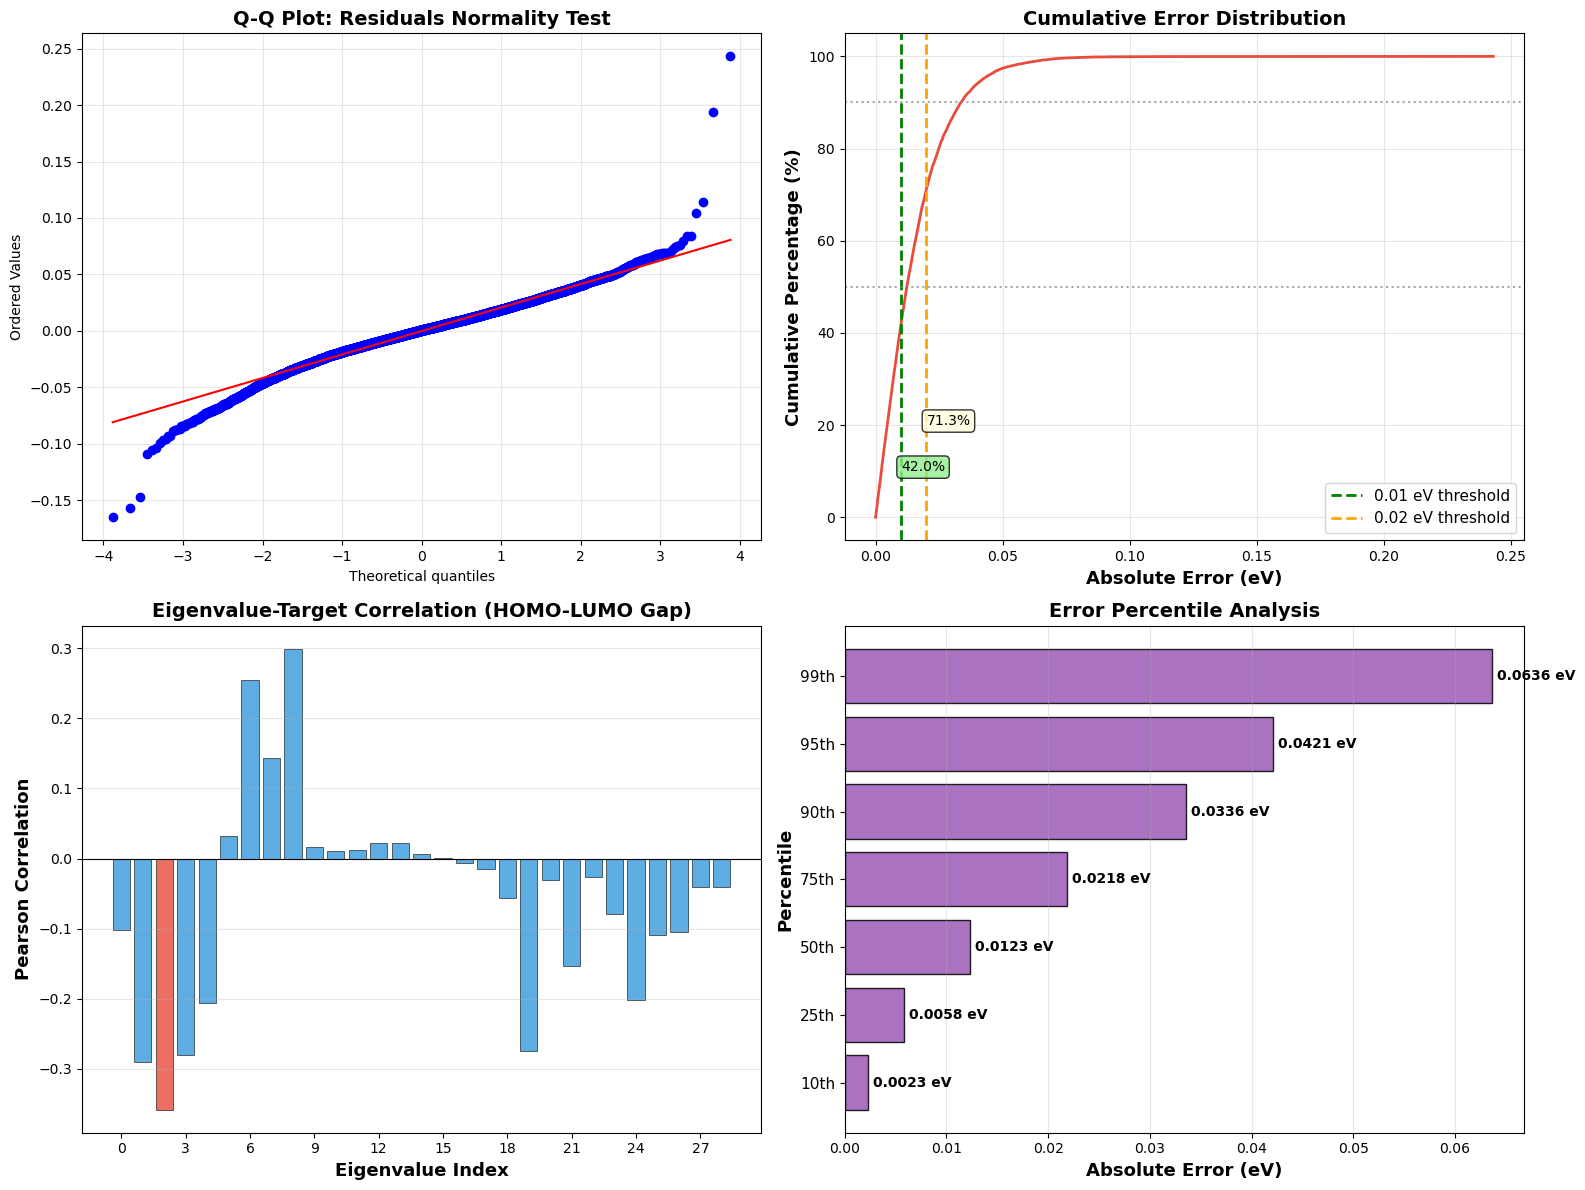


✓ Figure 4: Statistical Analysis saved and displayed!

 Key Statistics:
   • 42.0% of predictions within ±0.01 eV
   • 71.3% of predictions within ±0.02 eV
   • 50th percentile error: 0.0123 eV
   • 90th percentile error: 0.0336 eV


In [11]:
# Visualization 4: Statistical Analysis and Model Insights
fig4, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Q-Q Plot (Quantile-Quantile) for residuals normality check
from scipy import stats
ax1 = axes[0, 0]
stats.probplot(residuals, dist="norm", plot=ax1)
ax1.set_title('Q-Q Plot: Residuals Normality Test', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# 2. Cumulative Error Distribution
ax2 = axes[0, 1]
abs_errors = np.abs(residuals)
sorted_errors = np.sort(abs_errors)
cumulative_pct = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors) * 100
ax2.plot(sorted_errors, cumulative_pct, linewidth=2, color='#e74c3c')
ax2.axvline(x=0.01, color='green', linestyle='--', linewidth=2, label='0.01 eV threshold')
ax2.axvline(x=0.02, color='orange', linestyle='--', linewidth=2, label='0.02 eV threshold')
ax2.axhline(y=50, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
ax2.axhline(y=90, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
ax2.set_xlabel('Absolute Error (eV)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Cumulative Percentage (%)', fontsize=13, fontweight='bold')
ax2.set_title('Cumulative Error Distribution', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# Add percentage annotations
pct_below_01 = (abs_errors < 0.01).sum() / len(abs_errors) * 100
pct_below_02 = (abs_errors < 0.02).sum() / len(abs_errors) * 100
ax2.text(0.01, 10, f'{pct_below_01:.1f}%', fontsize=10, bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
ax2.text(0.02, 20, f'{pct_below_02:.1f}%', fontsize=10, bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

# 3. Eigenvalue Correlation with Target
ax3 = axes[1, 0]
correlations = []
for i in range(29):
    corr = np.corrcoef(X_evcm[:, i], y_evcm)[0, 1]
    correlations.append(corr)

colors_corr = ['#e74c3c' if abs(c) > 0.3 else '#3498db' for c in correlations]
bars = ax3.bar(range(29), correlations, color=colors_corr, edgecolor='black', linewidth=0.5, alpha=0.8)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax3.set_xlabel('Eigenvalue Index', fontsize=13, fontweight='bold')
ax3.set_ylabel('Pearson Correlation', fontsize=13, fontweight='bold')
ax3.set_title('Eigenvalue-Target Correlation (HOMO-LUMO Gap)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_xticks(range(0, 29, 3))

# 4. Error Percentile Analysis
ax4 = axes[1, 1]
percentiles = [10, 25, 50, 75, 90, 95, 99]
percentile_values = [np.percentile(abs_errors, p) for p in percentiles]

bars = ax4.barh(range(len(percentiles)), percentile_values, color='#9b59b6', edgecolor='black', linewidth=1, alpha=0.85)
ax4.set_yticks(range(len(percentiles)))
ax4.set_yticklabels([f'{p}th' for p in percentiles], fontsize=11)
ax4.set_xlabel('Absolute Error (eV)', fontsize=13, fontweight='bold')
ax4.set_ylabel('Percentile', fontsize=13, fontweight='bold')
ax4.set_title('Error Percentile Analysis', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

# Add value labels
for bar, val in zip(bars, percentile_values):
    ax4.text(val + 0.0005, bar.get_y() + bar.get_height()/2, f'{val:.4f} eV', 
             va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('/home/sattar/Documents/Dataset/QM9 data/fig4_statistical_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Figure 4: Statistical Analysis saved and displayed!")
print(f"\n Key Statistics:")
print(f"   • {pct_below_01:.1f}% of predictions within ±0.01 eV")
print(f"   • {pct_below_02:.1f}% of predictions within ±0.02 eV")
print(f"   • 50th percentile error: {percentile_values[2]:.4f} eV")
print(f"   • 90th percentile error: {percentile_values[4]:.4f} eV")
